In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchio as tio
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms


from modules.Dataset import FeTADataSet
from modules.LossFunctions import GDiceLossV2, DC_and_CE_loss
from modules.UNet import UNet2Dv2
from modules.Utils import calculate_dice_score, create_onehot_mask, init_weights_kaiming
from modules.Utils import TensorboardModules 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters 
num_epochs = 250
batch_size_ = 1
lr_ = 0.01
momentum_ = 0.9
nesterov_ = True
weight_path = "weights/UNet2D/run3"
shape = (256, 256, 256)

tb = TensorboardModules(os.path.join(weight_path, "events"))

In [3]:
labels = pd.read_csv("feta_2.1/dseg.tsv", sep='\t', index_col="index")

transform_ = transforms.Compose([tio.ZNormalization(masking_method=tio.ZNormalization.mean)])

train = FeTADataSet(train=True, transform=transform_)
test = FeTADataSet(train=False, transform=transform_)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size_)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size_)

In [4]:
### Add some images and corresponding masks into Tensorboard.
#mri_image, mri_mask = test[9]
#slices = (50, 150, 10)
#tb.add_images("Fetal Brain Images", mri_image, slices)
#tb.add_images("Fetal Brain Masks", mri_mask, slices)

In [5]:
model = UNet2Dv2().to(device)
model.apply(init_weights_kaiming)

# Add model graph to Tensorboard.
tb.add_graph(model, (256, 256), device)
#print(summary(model, input_size=(1, 256, 256)))

criterion = DC_and_CE_loss({'batch_dice': True, 'smooth': 1e-5, 'do_bg': False, 'square': False}, {})
optimizer = torch.optim.SGD(model.parameters(), lr=lr_, momentum=momentum_, nesterov=nesterov_)

/home/ugurcan/Programming/Python/Envs/cv4py3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
count_forward = 0
n_total_steps = len(train_loader)
running_loss = 0.0
running_dice_scores = torch.zeros(8).to(device)
bs_2d = 16

for epoch in range(num_epochs):
    for i, (image, mask) in enumerate(train_loader):
        image = image.to(device) #[bs,x,y,z]        
        mask = mask.to(device) #[x,y,z]
                
        for slice_ix in range(0, 255, bs_2d):
            slice_image = image[0, :, :, slice_ix:slice_ix+bs_2d].permute(2, 0, 1) #to get axial slice [:, :, index]
            slice_mask = mask[0, :, :, slice_ix:slice_ix+bs_2d].permute(2, 0, 1)
            slice_image = slice_image.view(bs_2d, 1, 256, 256)
            slice_mask = slice_mask.view(bs_2d, 1, 256, 256)
            
            unique, counts = torch.unique(slice_mask, return_counts=True) 

            # if the label count below the 16 pixel don't train with it.            
            if torch.any(counts[1:]>50):                
                outputs = model(slice_image.float())

                one_hot_mask = create_onehot_mask(outputs.shape, slice_mask, device)
                loss = criterion(outputs, slice_mask)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Sum losses and dice scores for all predicitions.
                running_loss += loss.item()
                scores = calculate_dice_score(F.softmax(outputs, dim=1), one_hot_mask)
                running_dice_scores += scores
                count_forward += 1
        
        
        #if (i+1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}")
    model_name = "_".join([str(epoch+1), str(lr_), str(nesterov_), "model.pth"])
    torch.save(model.state_dict(), os.path.join(weight_path, model_name))
                
    step = epoch * n_total_steps + i
    
    #Add average loss per 10th step to Tensorboard.
    avg_loss = running_loss / count_forward
    tb.add_loss(avg_loss, step)
    
    #Add average dice score per 10th step to Tensorboard.
    avg_scores = running_dice_scores / count_forward
    tb.add_dice_score(avg_scores, step)
    
    #Set values to zero for new calculations.
    count_forward = 0
    running_loss = 0.0
    running_dice_scores[:] = 0 

print('Finished Training')

In [6]:
model.load_state_dict(torch.load("weights/UNet2D/139_0.01_True_model.pth"))
model.eval()

UNet2Dv2(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3)

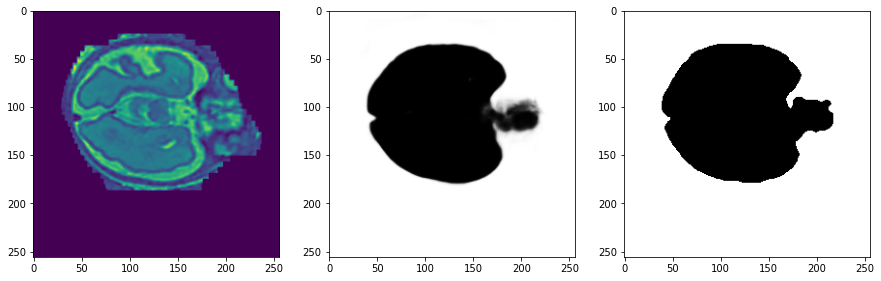

In [25]:
# Show results.
im_id = 4
slice_id = 72
class_index = 0

image, mask = test[im_id]
image = torch.Tensor(image)

inp = image[:, :, slice_id].view(1, 1, 256, 256)
inp = torch.Tensor(inp).to(device)
out = F.softmax(model(inp.float()), dim=1)

gt = torch.Tensor(mask[:, :, slice_id]).view(1, 1, 256, 256)
gt = create_onehot_mask(out.shape, gt.to(device), device)

fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(image[:, :, slice_id])
ax[1].imshow(out[0, class_index].cpu().detach().numpy(), cmap="gray")
ax[2].imshow(gt[0, class_index].cpu(), cmap="gray")
plt.show()